# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [54]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [55]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision import datasets, transforms

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [56]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downconv(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upconv(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.pool(x))

class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # return x.view(x.size(0), -1, 1, 1)
        return self.unflatten(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downconv(x)
        return self.convblock(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        return self.convblock(x)

## Implementing Unconditional UNet

In [57]:
class UnconditionalUNet(nn.Module):
    def __init__(self, in_channels: int, num_hiddens: int):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)  # Change here to match input channels
        self.downblock1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.downblock2 = DownBlock(num_hiddens * 2, num_hiddens * 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 4)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens * 2)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens, num_hiddens)

        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)

        x_bottleneck = self.flatten(x3)
        x_bottleneck = self.unflatten(x_bottleneck)

        x4 = self.upblock1(x_bottleneck + x3)
        x5 = self.upblock2(x4 + x2)
        x_out = self.convblock2(x5 + x1)

        return self.final_conv(x_out)

Part 1.2.1

Epoch [1/5], Loss: 0.052891
Epoch [2/5], Loss: 0.016098
Epoch [3/5], Loss: 0.015180
Epoch [4/5], Loss: 0.013833
Epoch [5/5], Loss: 0.013135


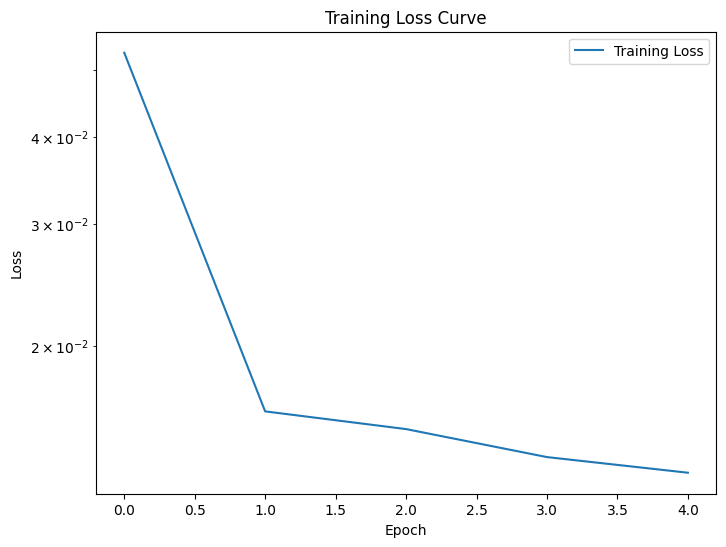

In [59]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(), lambda x: x * 2 - 1])  # Normalize to [-1, 1]
mnist_train = datasets.MNIST(root="mnist_data", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="mnist_data", train=False, transform=transform, download=True)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

def add_noise(images, sigma=0.5):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)  # 1 input channel for MNIST

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

epochs = 5
losses = []

for epoch in range(epochs):
    unet.train()
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, sigma=0.5).to(device)

        outputs = unet(noisy_images)

        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]:.6f}")

plt.figure(figsize=(8, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.yscale("log")
plt.legend()
plt.show()

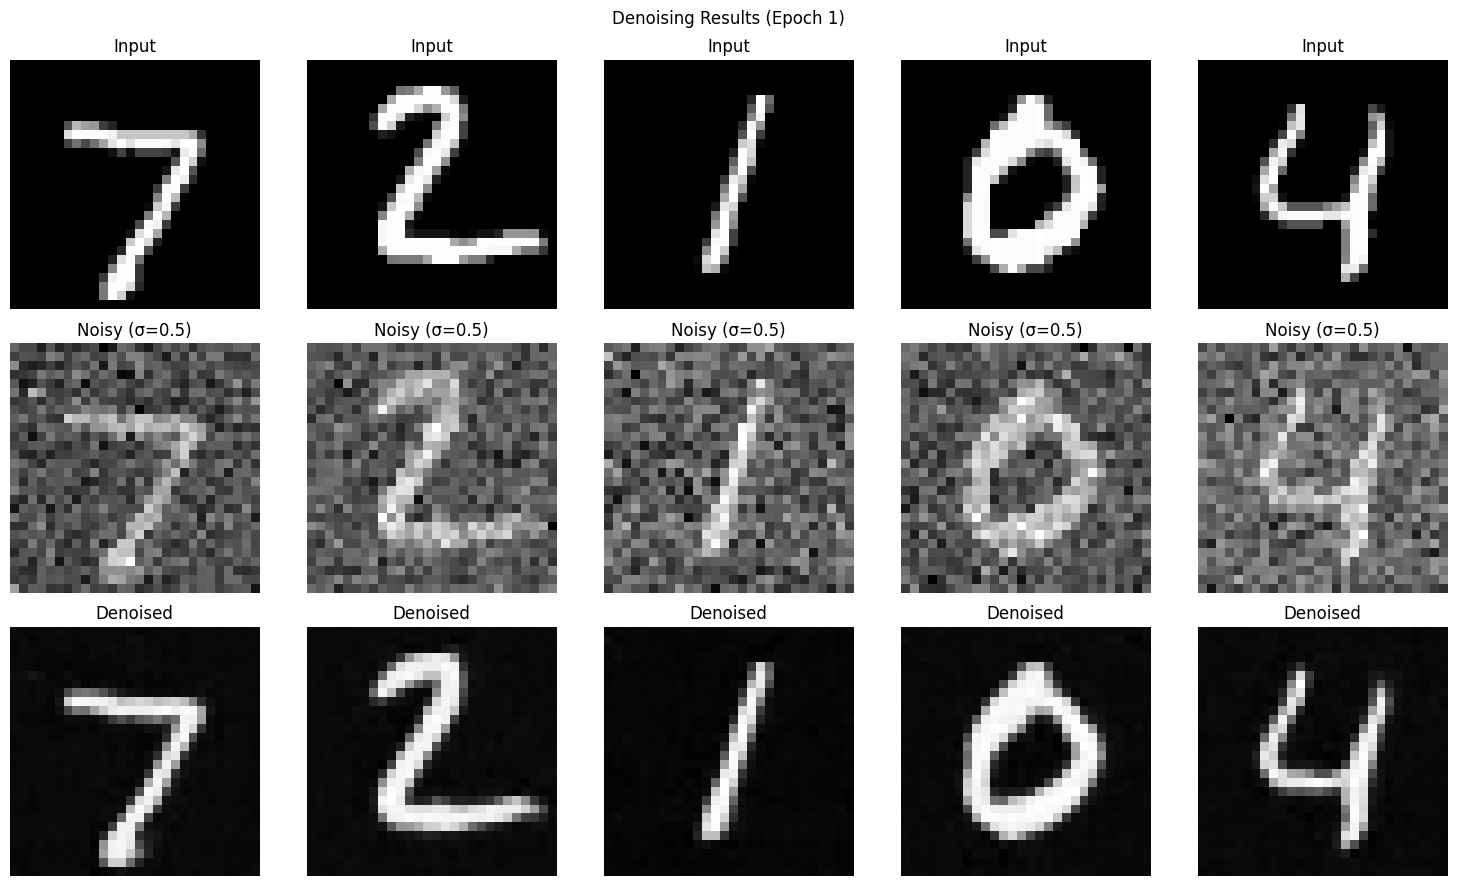

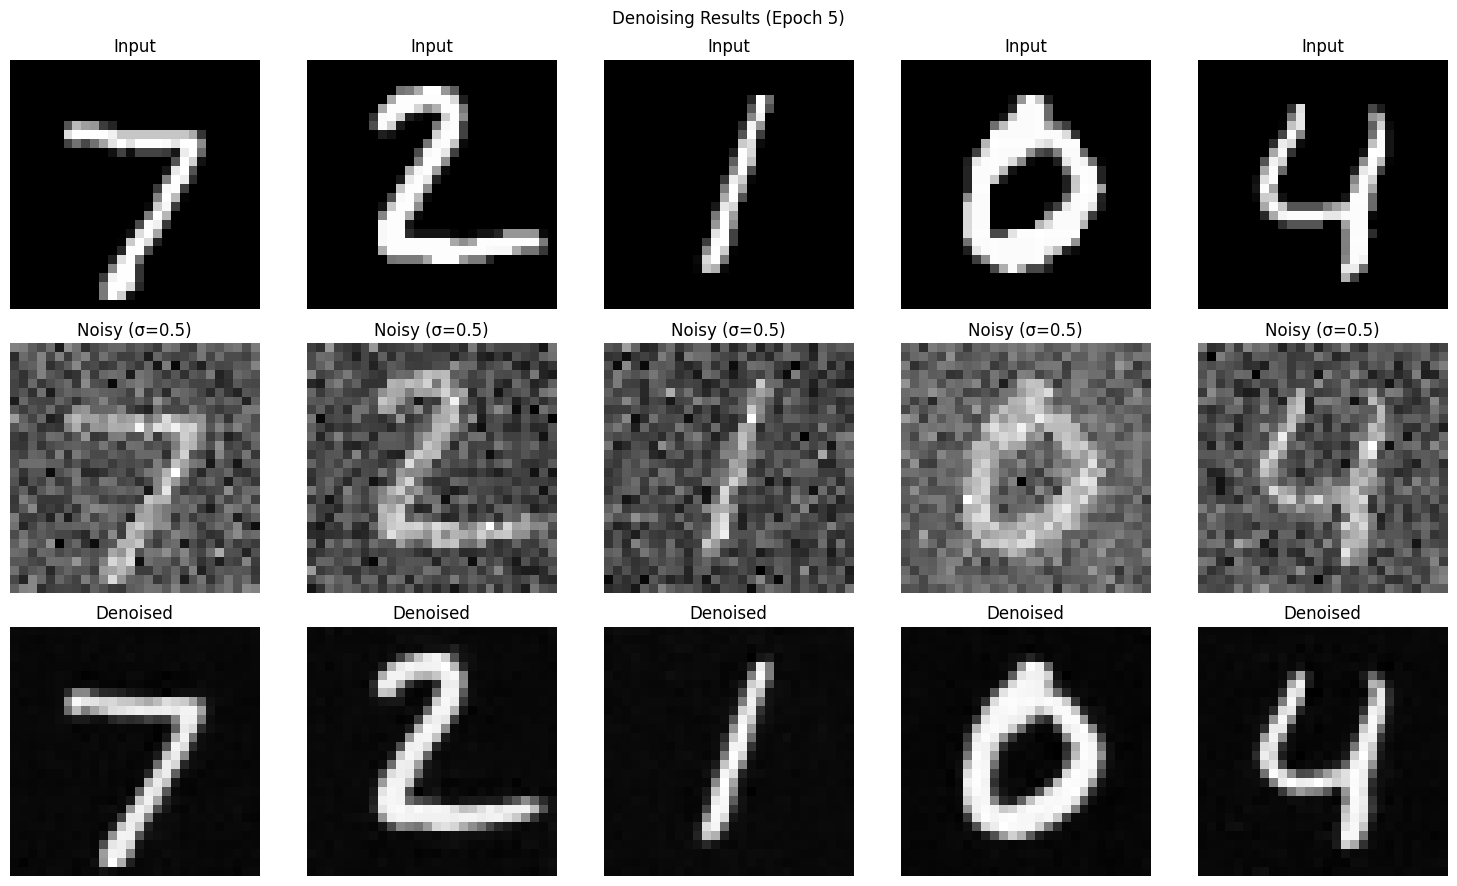

In [60]:
def visualize_denoising(test_loader, model, sigma=0.5, epoch=""):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            noisy_images = add_noise(images, sigma).to(device)
            denoised_images = model(noisy_images)

            images = (images + 1) / 2
            noisy_images = (noisy_images + 1) / 2
            denoised_images = (denoised_images + 1) / 2

            fig, axes = plt.subplots(3, 5, figsize=(15, 9))
            for i in range(5):
                axes[0, i].imshow(images[i][0].cpu(), cmap="gray")
                axes[0, i].set_title("Input")
                axes[0, i].axis("off")

                axes[1, i].imshow(noisy_images[i][0].cpu(), cmap="gray")
                axes[1, i].set_title(f"Noisy (σ={sigma})")
                axes[1, i].axis("off")

                axes[2, i].imshow(denoised_images[i][0].cpu(), cmap="gray")
                axes[2, i].set_title("Denoised")
                axes[2, i].axis("off")

            plt.suptitle(f"Denoising Results (Epoch {epoch})")
            plt.tight_layout()
            plt.show()
            break

visualize_denoising(test_loader, unet, sigma=0.5, epoch="1")
visualize_denoising(test_loader, unet, sigma=0.5, epoch="5")

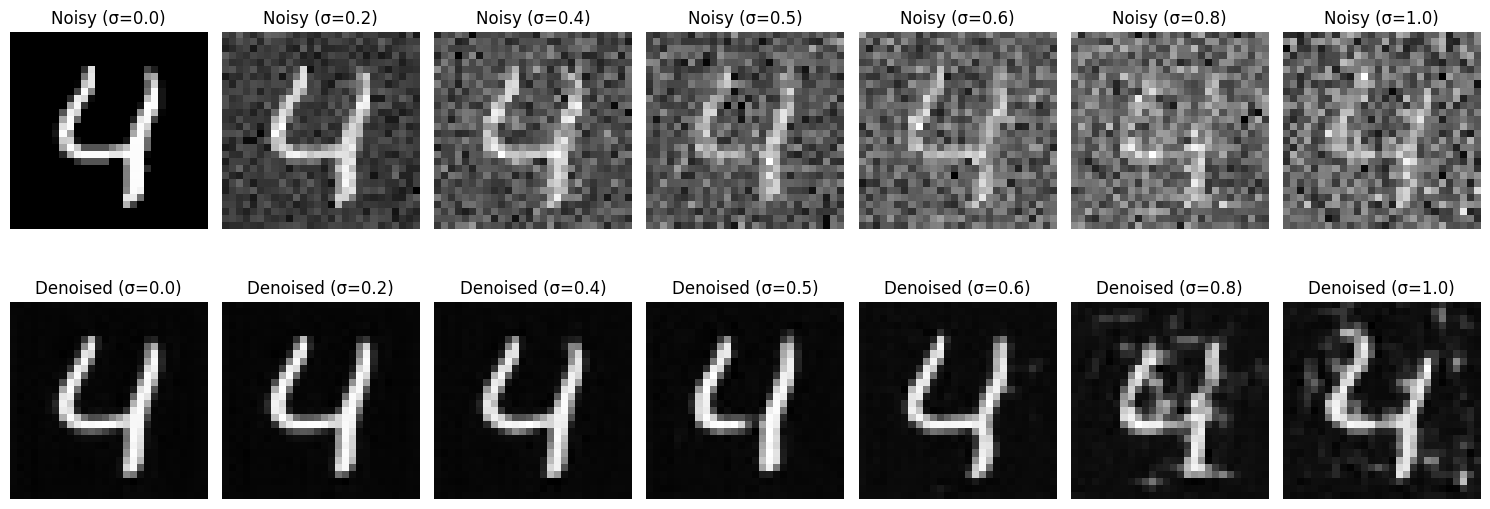

In [7]:
def test_denoiser_on_varying_sigma(model, test_loader, sigmas, display_count=5):
    """
    Tests the denoiser on test images with varying levels of noise and visualizes results.
    Args:
        model: Trained denoiser model.
        test_loader: DataLoader for test data.
        sigmas: List of noise levels to test.
        display_count: Number of samples to display.
    """
    model.eval()
    images_to_test = []
    noisy_outputs = {}
    denoised_outputs = {}

    with torch.no_grad():
        for images, _ in test_loader:
            images = images[:display_count].to(device)
            images_to_test = images

            for sigma in sigmas:
                noisy_images = add_noise(images, sigma=sigma).to(device)
                denoised_images = model(noisy_images)

                noisy_outputs[sigma] = noisy_images.cpu()
                denoised_outputs[sigma] = denoised_images.cpu()

            break

    fig, axes = plt.subplots(2, len(sigmas), figsize=(15, 6))
    for col, sigma in enumerate(sigmas):
        noisy_images = noisy_outputs[sigma]
        for i in range(display_count):
            axes[0, col].imshow((noisy_images[i][0] + 1) / 2, cmap="gray")
            axes[0, col].set_title(f"Noisy (σ={sigma})")
            axes[0, col].axis("off")

        denoised_images = denoised_outputs[sigma]
        for i in range(display_count):
            axes[1, col].imshow((denoised_images[i][0] + 1) / 2, cmap="gray")
            axes[1, col].set_title(f"Denoised (σ={sigma})")
            axes[1, col].axis("off")

    plt.tight_layout()
    plt.show()

sigma_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
test_denoiser_on_varying_sigma(unet, test_loader, sigma_levels, display_count=5)

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [51]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of FCBlock.
        Args:
            x: (N, in_channels) input tensor.
        Returns:
            (N, out_channels) output tensor.
        """
        return self.fc(x)


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.fc1_t = FCBlock(1, num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)

        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.downblock2 = DownBlock(num_hiddens * 2, num_hiddens * 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 4)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens * 2)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens, num_hiddens)

        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Forward pass of the model.
        Args:
            x: (N, C, H, W) input tensor (image).
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = torch.clamp(t, min=1e-5, max=1-1e-5)

        t1 = self.fc1_t(t.unsqueeze(-1))
        t2 = self.fc2_t(t.unsqueeze(-1))

        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)

        x_bottleneck = self.flatten(x3)
        t1_projected = nn.Linear(t1.size(1), x_bottleneck.size(1)).to(t1.device)(t1)
        x_bottleneck = self.unflatten(x_bottleneck + t1_projected.view(t1.size(0), -1, 1, 1))

        x4 = self.upblock1(x_bottleneck + x3)
        t2_projected = nn.Linear(t2.size(1), x4.size(1)).to(t2.device)(t2)
        x5 = self.upblock2(x4 + x2 + t2_projected.view(t2.size(0), -1, 1, 1))

        x_out = self.convblock2(x5 + x1)

        return self.final_conv(x_out)

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [22]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts)

    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "betas": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
    }

In [21]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.

    Returns:
        torch.Tensor: diffusion loss.
    """
    unet.train()
    device = x_0.device

    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    t = torch.randint(0, num_ts, (x_0.size(0),), device=device).long()

    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1.0 - alpha_bar_t) * epsilon

    epsilon_pred = unet(x_t, t / num_ts)

    loss = F.mse_loss(epsilon_pred, epsilon)

    return loss

In [20]:
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
hidden_dim = 64
num_timesteps = 1000

transform = transforms.Compose([transforms.ToTensor(), lambda x: x * 2 - 1])  # Normalize to [-1, 1]
mnist_train = datasets.MNIST(root="mnist_data", train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=hidden_dim).to(device)

ddpm_schedule_params = {k: v.to(device) for k, v in ddpm_schedule(beta1=1e-4, beta2=0.02, num_ts=num_timesteps).items()}

optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / num_epochs))

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0

    for x_0, _ in train_loader:
        x_0 = x_0.to(device)

        t = torch.randint(0, num_timesteps, (x_0.size(0),), device=device)
        t_normalized = t / num_timesteps

        epsilon = torch.randn_like(x_0)

        alpha_bar_t = ddpm_schedule_params["alpha_bars"][t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon

        epsilon_pred = unet(x_t, t_normalized)

        loss = F.mse_loss(epsilon_pred, epsilon)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.6f}")

torch.save(unet.state_dict(), "time_conditioned_unet.pth")

Epoch [1/20], Loss: 0.066565
Epoch [2/20], Loss: 0.039814
Epoch [3/20], Loss: 0.036036
Epoch [4/20], Loss: 0.034650
Epoch [5/20], Loss: 0.032185
Epoch [6/20], Loss: 0.031263
Epoch [7/20], Loss: 0.030399
Epoch [8/20], Loss: 0.029083
Epoch [9/20], Loss: 0.028540
Epoch [10/20], Loss: 0.028205
Epoch [11/20], Loss: 0.027766
Epoch [12/20], Loss: 0.027359
Epoch [13/20], Loss: 0.026740
Epoch [14/20], Loss: 0.026178
Epoch [15/20], Loss: 0.026099
Epoch [16/20], Loss: 0.026136
Epoch [17/20], Loss: 0.025892
Epoch [18/20], Loss: 0.025186
Epoch [19/20], Loss: 0.025576
Epoch [20/20], Loss: 0.025379


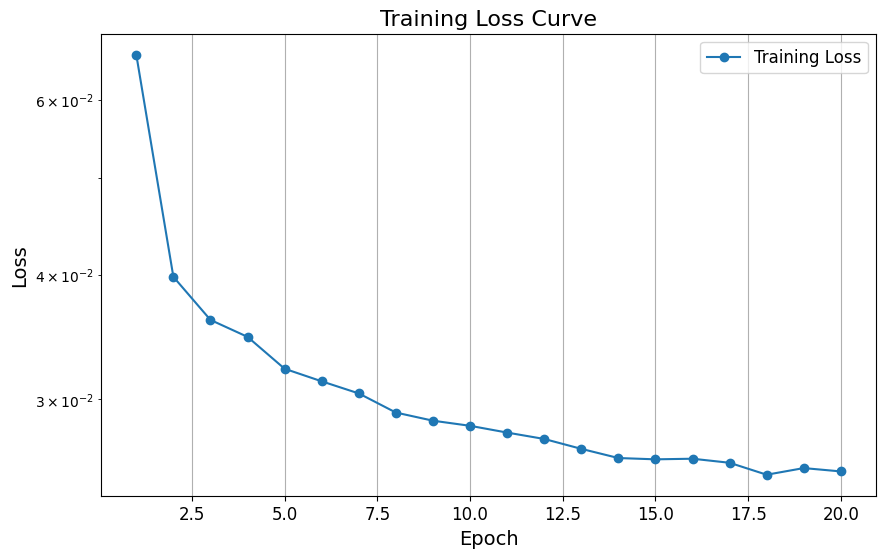

In [23]:
import matplotlib.pyplot as plt

losses = [
    0.066565, 0.039814, 0.036036, 0.034650, 0.032185,
    0.031263, 0.030399, 0.029083, 0.028540, 0.028205,
    0.027766, 0.027359, 0.026740, 0.026178, 0.026099,
    0.026136, 0.025892, 0.025186, 0.025576, 0.025379,
]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label="Training Loss")
plt.title("Training Loss Curve", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [49]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper."""

    torch.manual_seed(seed)

    device = next(unet.parameters()).device
    betas = ddpm_schedule["betas"].to(device)
    alphas = ddpm_schedule["alphas"].to(device)
    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    img_shape = (1, 1, img_wh[0], img_wh[1])  # (N, C, H, W)
    x_t = torch.randn(img_shape, device=device)

    for t in range(num_ts, 0, -1):
        t_normalized = t / num_ts
        t_tensor = torch.full((x_t.size(0),), t_normalized, device=device)

        epsilon_pred = unet(x_t, t_tensor)

        print(epsilon_pred)

        assert not torch.isnan(epsilon_pred).any(), "epsilon_pred contains NaN values"

        sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t - 1])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t - 1])
        x_0_hat = (x_t - sqrt_one_minus_alpha_bar_t * epsilon_pred) / sqrt_alpha_bar_t

        if t > 1:
            z = torch.randn_like(x_t)
        else:
            z = 0

        beta_t = betas[t - 1]
        alpha_bar_t_minus_1 = alpha_bars[t - 2] if t > 1 else torch.tensor(1.0, device=device)

        coeff_1 = torch.sqrt(alpha_bar_t_minus_1 / alpha_bars[t - 1])  # For x_0_hat
        coeff_2 = torch.sqrt(1 - alpha_bar_t_minus_1) / torch.sqrt(1 - alpha_bars[t - 1])  # For x_t
        x_t = coeff_1 * x_0_hat + coeff_2 * x_t + torch.sqrt(beta_t) * z
        assert not torch.isnan(x_t).any(), f"x_t contains NaN values at step {t}"

    return x_t

In [24]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(f"ddpm_{k}", v.to(torch.float32), persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

Epoch [1/20], Loss: 0.099301
Epoch [2/20], Loss: 0.063553
Epoch [3/20], Loss: 0.057953
Epoch [4/20], Loss: 0.056051
Epoch [5/20], Loss: 0.053145
Epoch [6/20], Loss: 0.050965
Epoch [7/20], Loss: 0.050151
Epoch [8/20], Loss: 0.049820
Epoch [9/20], Loss: 0.048231
Epoch [10/20], Loss: 0.047549
Epoch [11/20], Loss: 0.046732
Epoch [12/20], Loss: 0.046277
Epoch [13/20], Loss: 0.045869
Epoch [14/20], Loss: 0.045258
Epoch [15/20], Loss: 0.044492
Epoch [16/20], Loss: 0.044198
Epoch [17/20], Loss: 0.043691
Epoch [18/20], Loss: 0.043658
Epoch [19/20], Loss: 0.043395
Epoch [20/20], Loss: 0.043046


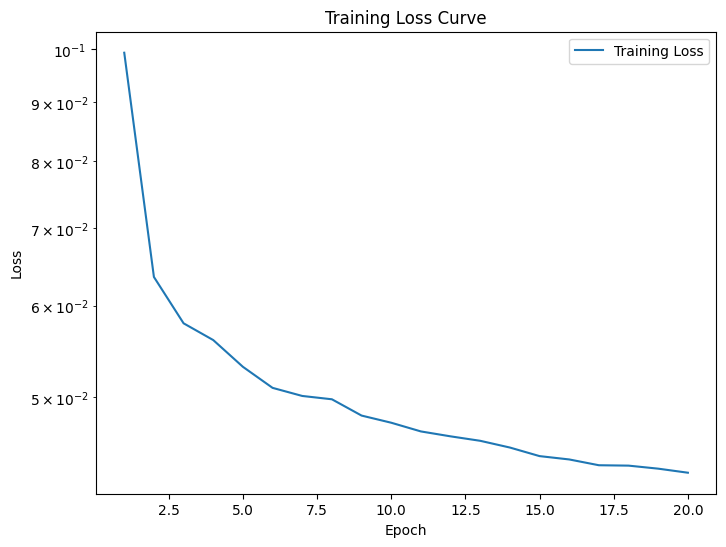

In [25]:
import matplotlib.pyplot as plt

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64)
ddpm = DDPM(unet).to(device)

optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1.0 / 20))  # For 20 epochs

losses = []
epochs = 20

for epoch in range(epochs):
    ddpm.train()
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        loss = ddpm(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    scheduler.step()

    if epoch + 1 in [5, 20]:
        torch.save(ddpm.state_dict(), f"ddpm_epoch_{epoch + 1}.pth")

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {losses[-1]:.6f}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
@torch.inference_mode()
def generate_samples_for_epoch(ddpm, epoch, num_samples=16, img_wh=(28, 28)):
    ddpm.eval()

    samples = []
    for seed in range(num_samples):
        sample = ddpm_sample(
            unet=ddpm.unet,
            ddpm_schedule=ddpm.ddpm_schedule,
            img_wh=img_wh,
            num_ts=ddpm.num_ts,
            seed=seed,
        )
        print("-----")
        print(sample.squeeze(0))

        samples.append(sample.squeeze(0).cpu())
    samples = torch.stack(samples)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, img in enumerate(samples):
        row, col = divmod(i, 4)
        ax = axes[row, col]
        img = img.squeeze(0)
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    fig.suptitle(f"Samples at Epoch {epoch}", fontsize=16)
    plt.tight_layout()
    plt.show()

for epoch in [5]:
    ddpm.load_state_dict(torch.load(f"ddpm_epoch_{epoch}.pth"))
    generate_samples_for_epoch(ddpm, epoch)

### Implementing class-conditioned UNet

In [14]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens
        self.in_channels = in_channels

        self.fc1_t = FCBlock(1, num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)

        self.fc1_c = FCBlock(num_classes, num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.downblock1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.downblock2 = DownBlock(num_hiddens * 2, num_hiddens * 4)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 4)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens * 2)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens, num_hiddens)

        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        c_one_hot = F.one_hot(c, num_classes=self.num_classes).float()

        if mask is not None:
            c_one_hot = c_one_hot * mask.unsqueeze(-1)

        t1 = self.fc1_t(t.unsqueeze(-1))
        c1 = self.fc1_c(c_one_hot)
        t2 = self.fc2_t(t.unsqueeze(-1))
        c2 = self.fc2_c(c_one_hot)

        x1 = self.convblock1(x)
        x2 = self.downblock1(x1)
        x3 = self.downblock2(x2)

        x_bottleneck = self.flatten(x3)

        t1_projected = nn.Linear(t1.size(1), x_bottleneck.size(1)).to(t1.device)(t1)
        c1_projected = nn.Linear(c1.size(1), x_bottleneck.size(1)).to(c1.device)(c1)
        x_bottleneck = self.unflatten(c1_projected * x_bottleneck + t1_projected)

        x4 = self.upblock1(x_bottleneck + x3)

        t2_projected = nn.Linear(t2.size(1), x4.size(1)).to(t2.device)(t2)
        c2_projected = nn.Linear(c2.size(1), x4.size(1)).to(c2.device)(c2)
        x5 = self.upblock2(c2_projected * x4 + x2 + t2_projected)

        x_out = self.convblock2(x5 + x1)

        return self.final_conv(x_out)

In [15]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    device = x_0.device

    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    t = torch.randint(0, num_ts, (x_0.size(0),), device=device).long()

    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1.0 - alpha_bar_t) * epsilon

    mask = torch.bernoulli((1 - p_uncond) * torch.ones_like(t, dtype=torch.float32, device=device)).long()

    epsilon_pred = unet(x_t, c, t / num_ts, mask=mask)

    loss = F.mse_loss(epsilon_pred, epsilon)

    return loss

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    torch.manual_seed(seed)

    device = next(unet.parameters()).device
    betas = ddpm_schedule["betas"].to(device)
    alphas = ddpm_schedule["alphas"].to(device)
    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    img_shape = (1, 1, img_wh[0], img_wh[1])  # (N, C, H, W)
    x_t = torch.randn(img_shape, device=device)

    for t in range(num_ts, 0, -1):
        t_normalized = t / num_ts
        t_tensor = torch.full((x_t.size(0),), t_normalized, device=device)

        epsilon_pred = unet(x_t, t_tensor)

        print(epsilon_pred)

        assert not torch.isnan(epsilon_pred).any(), "epsilon_pred contains NaN values"

        sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t - 1])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t - 1])
        x_0_hat = (x_t - sqrt_one_minus_alpha_bar_t * epsilon_pred) / sqrt_alpha_bar_t

        if t > 1:
            z = torch.randn_like(x_t)
        else:
            z = 0

        beta_t = betas[t - 1]
        alpha_bar_t_minus_1 = alpha_bars[t - 2] if t > 1 else torch.tensor(1.0, device=device)

        coeff_1 = torch.sqrt(alpha_bar_t_minus_1 / alpha_bars[t - 1])  # For x_0_hat
        coeff_2 = torch.sqrt(1 - alpha_bar_t_minus_1) / torch.sqrt(1 - alpha_bars[t - 1])  # For x_t
        x_t = coeff_1 * x_0_hat + coeff_2 * x_t + torch.sqrt(beta_t) * z
        assert not torch.isnan(x_t).any(), f"x_t contains NaN values at step {t}"

    return x_t

In [16]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
ddpm = DDPM(unet, num_ts=300, p_uncond=0.1).to(device)

optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1.0 / 20))  # For 20 epochs

losses = []
for epoch in range(epochs):
    ddpm.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        loss = ddpm(images, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {losses[-1]:.6f}")

    if epoch + 1 in [5, 20]:
        torch.save(ddpm.state_dict(), f"ddpm_epoch_{epoch + 1}.pth")

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Class-Conditioned UNet Training Loss Curve")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()